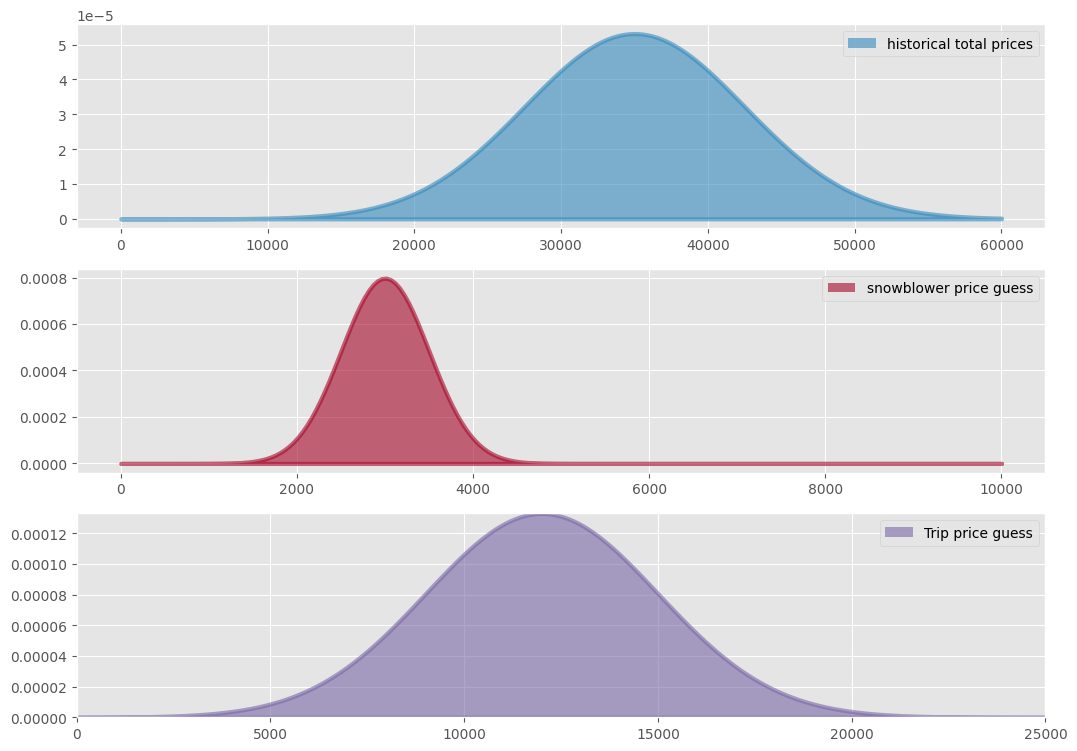

In [1]:
# %matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mtl
mtl.style.use("ggplot")

figsize(12.5, 9)

norm_pdf = stats.norm.pdf

plt.subplot(311)
x = np.linspace(0, 60000, 200)
sp1 = plt.fill_between(x , 0, norm_pdf(x, 35000, 7500), 
                color = "#348ABD", lw = 3, alpha = 0.6,
                label = "historical total prices")
p1 = plt.Rectangle((0, 0), 1, 1, fc=sp1.get_facecolor()[0])
plt.legend([p1], [sp1.get_label()])

plt.subplot(312)
x = np.linspace(0, 10000, 200)
sp2 = plt.fill_between(x , 0, norm_pdf(x, 3000, 500), 
                 color = "#A60628", lw = 3, alpha = 0.6,
                 label="snowblower price guess")

p2 = plt.Rectangle((0, 0), 1, 1, fc=sp2.get_facecolor()[0])
plt.legend([p2], [sp2.get_label()])

plt.subplot(313)
x = np.linspace(0, 25000, 200)
sp3 = plt.fill_between(x , 0, norm_pdf(x, 12000, 3000), 
                 color = "#7A68A6", lw = 3, alpha = 0.6,
                 label = "Trip price guess")
plt.autoscale(tight=True)
p3 = plt.Rectangle((0, 0), 1, 1, fc=sp3.get_facecolor()[0])
plt.legend([p3], [sp3.get_label()])

In [2]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, HMC
import numpy as np
import torch

/home/user/pyro/env_3_10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_mu = [3e3, 12e3]

data_std =  [5e2, 3e3] 

mu_prior = 35e3
std_prior =  75e2

def model():
    true_price = pyro.sample('true_price', dist.Normal(mu_prior, std_prior))

    price_1 = pyro.sample('price_1', dist.Normal(data_mu[0], data_std[0]))
    price_2 = pyro.sample('price_2', dist.Normal(data_mu[1], data_std[1]))

    price_estimate = price_1 + price_2
    # lets say we dont know that sum of 2 independent Norm equals to Norm
    # and say sigma price_estimate = 3e3 (because the authors have taken that)
    pyro.sample('obs', dist.Normal(price_estimate, 3e3), obs=true_price)

kernel = NUTS(model, jit_compile=True, ignore_jit_warnings=True, max_tree_depth=3)
posterior = MCMC(kernel, num_samples=5000, warmup_steps=1000)
posterior.run()

Sample: 100%|██████████| 6000/6000 [00:18, 317.57it/s, step size=5.07e-01, acc. prob=0.940]


In [4]:
price_trace = posterior.get_samples()['true_price']

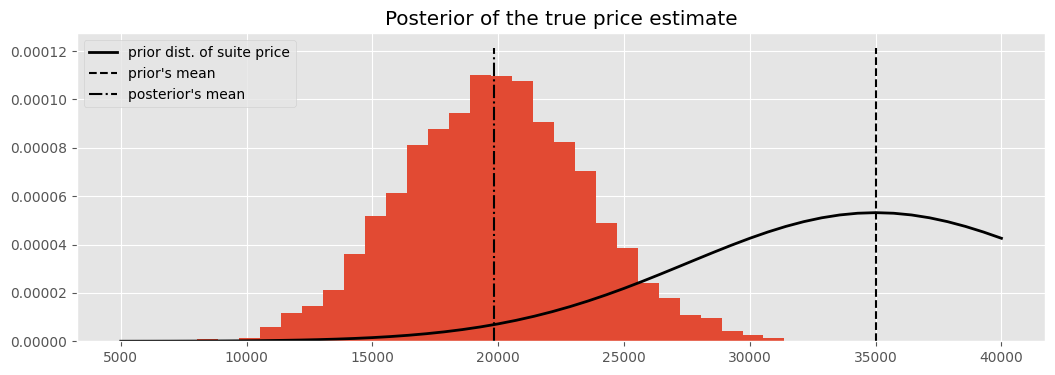

In [5]:
figsize(12.5, 4)

import scipy.stats as stats

x = np.linspace(5000, 40000)
plt.plot(x, stats.norm.pdf(x, 35000, 7500), c = "k", lw = 2, 
         label = "prior dist. of suite price")

_hist = plt.hist(price_trace, bins = 35, density= True, histtype= "stepfilled")
plt.title("Posterior of the true price estimate")
plt.vlines(mu_prior, 0, 1.1*np.max(_hist[0]), label = "prior's mean",
           linestyles="--",color="black")
plt.vlines(price_trace.mean(), 0, 1.1*np.max(_hist[0]), \
           label = "posterior's mean", linestyles="-.",color="black")
plt.legend(loc = "upper left")

(5000.0, 30000.0)

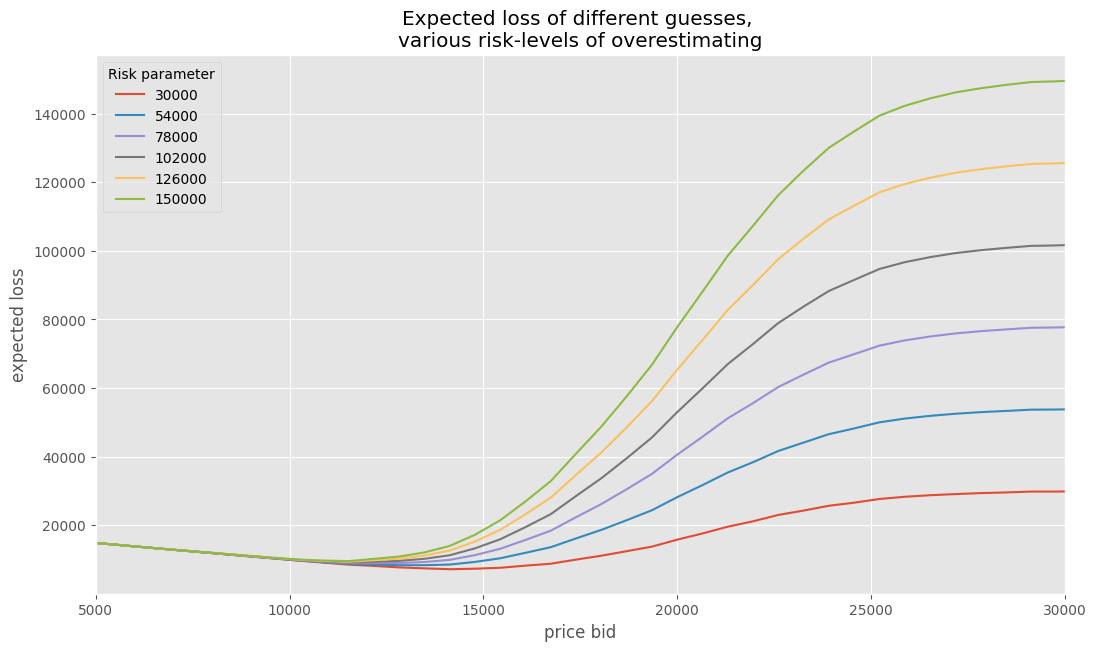

In [6]:
figsize(12.5, 7)
#numpy friendly showdown_loss


def showdown_loss(guess, true_price, risk = 80000):
        loss = np.zeros_like(true_price)
        ix = true_price < guess
        loss[~ix] = np.abs(guess - true_price[~ix])
        close_mask = abs(true_price - guess) <= 250
        loss[close_mask] = -2*true_price[close_mask]
        loss[ix] = risk
        return loss


guesses = np.linspace(5000, 50000, 70) 
risks = np.linspace(30000, 150000, 6)
expected_loss = lambda guess, risk: \
    showdown_loss(guess, price_trace, risk).mean()

for _p in risks:
    results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, results, label = "%d"%_p)
    
plt.title("Expected loss of different guesses, \nvarious risk-levels of \
overestimating")
plt.legend(loc="upper left", title="Risk parameter")
plt.xlabel("price bid")
plt.ylabel("expected loss")
plt.xlim(5000, 30000)